In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf;
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import math

# Load data with specified encoding and column names
column_names = ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle', '2020', '2021', '2022']
dataset = pd.read_csv('../20244281821457313338UHELDK129906013912.csv', names=column_names, sep=';', encoding='ISO-8859-1')

# Data preprocessing
dataset['Type of Vehicle'] = dataset['Type of Vehicle'].replace(['Knallert 45'], 'Knallert')
dataset['Total Incidents'] = dataset[['2020', '2021', '2022']].sum(axis=1)
dataset.drop(['2020', '2021', '2022'], axis=1, inplace=True)
dataset = dataset[dataset['Type of Injury'] != 'Personskade i alt']

# Drop rows containing "uoplyst"
dataset = dataset[~dataset.applymap(lambda x: 'Uoplyst' in str(x)).any(axis=1)]

In [8]:
dataset

,Gender,Age,Type of Injury,Area,Type of Vehicle,Total Incidents
60,Mænd,0-17 år,Dræbte,Region Hovedstaden,Almindelig personbil,2
61,Mænd,0-17 år,Dræbte,Region Hovedstaden,Taxi,0
62,Mænd,0-17 år,Dræbte,Region Hovedstaden,Køretøj 0-3.500 kg under udrykning,0
63,Mænd,0-17 år,Dræbte,Region Hovedstaden,Varebil 0-3.500 kg.,0
64,Mænd,0-17 år,Dræbte,Region Hovedstaden,Lastbil over 3.500 kg.,0
...,...,...,...,...,...,...
2635,Kvinder,65 år og derover,Lettere tilskadekomne,Region Nordjylland,Knallert,0
2636,Kvinder,65 år og derover,Lettere tilskadekomne,Region Nordjylland,Knallert,0
2637,Kvinder,65 år og derover,Lettere tilskadekomne,Region Nordjylland,Cykel,5
2638,Kvinder,65 år og derover,Lettere tilskadekomne,Region Nordjylland,Fodgænger,9


In [9]:
# Save the modified dataset to a new CSV file
dataset.to_csv('../modified_dataset.csv', index=False)

print("Dataset has been saved to 'modified_dataset.csv'.")

Dataset has been saved to 'modified_dataset.csv'.


In [6]:


# One-Hot Encoding
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(dataset[['Gender', 'Age', 'Area', 'Type of Vehicle']])
feature_names = encoder.get_feature_names_out(['Gender', 'Age', 'Area', 'Type of Vehicle'])  # Corrected line
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)
encoded_df['Total Incidents'] = dataset['Total Incidents'].values

# Prepare target
target = pd.get_dummies(dataset['Type of Injury'])

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(encoded_df, target, test_size=0.2, random_state=42)

# Model building
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='softmax'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='softmax'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [60]:
X_train.shape[1]

26

In [7]:
"""model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])"""

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=(1e-3)), 
              loss=SparseCategoricalCrossentropy(from_logits = False))

# Model training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.3, callbacks=[lrate])

# Model Evaluation
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test.values, axis=1)
print(confusion_matrix(true_classes, predicted_classes))
print(classification_report(true_classes, predicted_classes))

def predict_injury_type(user_data):
    input_df = pd.DataFrame([user_data])
    encoded_input = encoder.transform(input_df[['Gender', 'Age', 'Area', 'Type of Vehicle']])
    input_features = pd.DataFrame(encoded_input, columns=feature_names)
    
    # Ensure input features match the training data shape
    if input_features.shape[1] != X_train.shape[1]:
        missing_cols = set(X_train.columns) - set(input_features.columns)
        for col in missing_cols:
            input_features[col] = 0  # Adding missing columns as zeros
        input_features = input_features[X_train.columns]  # Reorder columns to match training data

    probabilities = model.predict(input_features)[0]
    injury_types = y_train.columns  # Using the columns from y_train for the class names
    return {injury_types[i]: prob for i, prob in enumerate(probabilities)}

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Program Files\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Program Files\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Program Files\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Program Files\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Program Files\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\kaspe\AppData\Local\Temp\ipykernel_8880\558424043.py", line 9, in <module>
      history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.3, callbacks=[lrate])
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\kaspe\AppData\Roaming\Python\Python310\site-packages\keras\src\backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [32,3] and labels shape [96]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_1842]

1/1 [==============================] - 0s 19ms/step
{'Alvorligt tilskadekomne': 0.3458257, 'Dræbte': 0.38858002, 'Lettere tilskadekomne': 0.26559424}


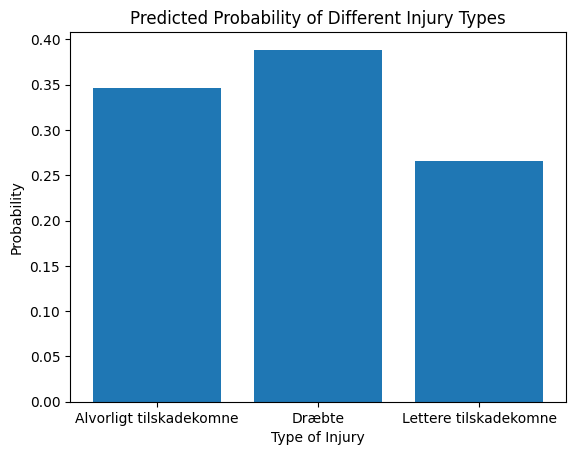

In [51]:
# Example user input
user_input = {
    'Gender': 'Mænd',
    'Age': '18-24 år',
    'Area': 'Region Sjælland',
    'Type of Vehicle': 'Knallert'
}
predicted_probabilities = predict_injury_type(user_input)
print(predicted_probabilities)

# Visualization of probabilities
plt.bar(range(len(predicted_probabilities)), list(predicted_probabilities.values()), align='center')
plt.xticks(range(len(predicted_probabilities)), list(predicted_probabilities.keys()))
plt.title('Predicted Probability of Different Injury Types')
plt.xlabel('Type of Injury')
plt.ylabel('Probability')
plt.show()

1/1 [==============================] - 0s 18ms/step
{'Alvorligt tilskadekomne': 0.011334058, 'Dræbte': 0.9126004, 'Lettere tilskadekomne': 0.07606566}


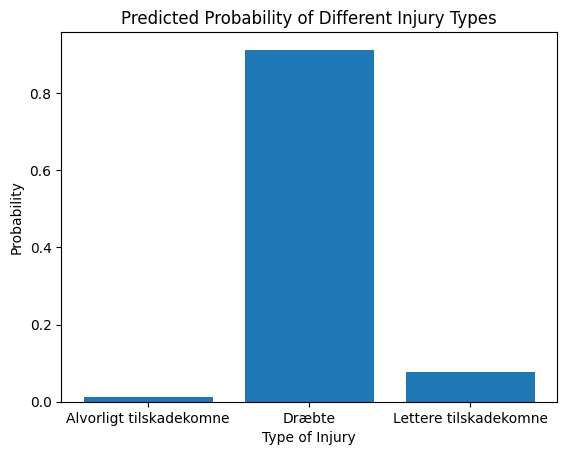

In [52]:
# Example user input
user_input = {
    'Gender': 'Mænd',
    'Age': '18-24 år',
    'Area': 'Region Hovedstaden',
    'Type of Vehicle': 'Fodgænger'
}
predicted_probabilities = predict_injury_type(user_input)
print(predicted_probabilities)

# Visualization of probabilities
plt.bar(range(len(predicted_probabilities)), list(predicted_probabilities.values()), align='center')
plt.xticks(range(len(predicted_probabilities)), list(predicted_probabilities.keys()))
plt.title('Predicted Probability of Different Injury Types')
plt.xlabel('Type of Injury')
plt.ylabel('Probability')
plt.show()

1/1 [==============================] - 0s 18ms/step
{'Alvorligt tilskadekomne': 0.0407852, 'Dræbte': 0.85230505, 'Lettere tilskadekomne': 0.10690973}


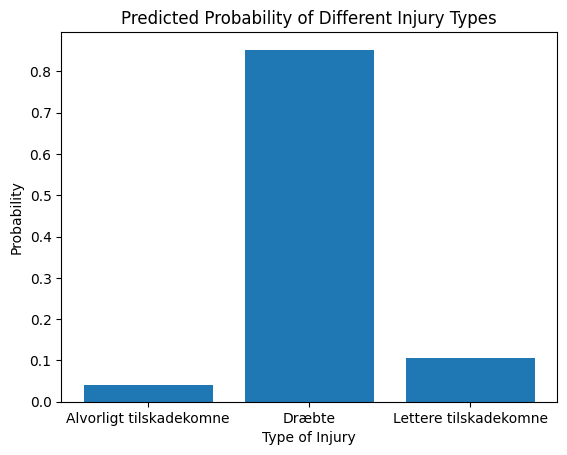

In [53]:
# Example user input
user_input = {
    'Gender': 'Kvinder',
    'Age': '65 år og derover',
    'Area': 'Region Syddanmark',
    'Type of Vehicle': 'Almindelig personbil'
}
predicted_probabilities = predict_injury_type(user_input)
print(predicted_probabilities)

# Visualization of probabilities
plt.bar(range(len(predicted_probabilities)), list(predicted_probabilities.values()), align='center')
plt.xticks(range(len(predicted_probabilities)), list(predicted_probabilities.keys()))
plt.title('Predicted Probability of Different Injury Types')
plt.xlabel('Type of Injury')
plt.ylabel('Probability')
plt.show()